In [1]:
library(tidyverse)

kyoto_df <- data.frame(data.table::fread("../A_outputs/A31_japan_temperature.csv"))
head(kyoto_df)
station_ids <- unique(kyoto_df$id)
length(station_ids)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


,id,date,tmax,tmin,prcp,year,month,day
,<chr>,<IDate>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,JA000047636,1951-01-01,6.6,-0.4,0.2,1951,1,1
2,JA000047636,1951-01-02,6.3,-2.5,0.0,1951,1,2
3,JA000047636,1951-01-03,7.8,-4.2,0.0,1951,1,3
4,JA000047636,1951-01-04,8.7,0.6,0.0,1951,1,4
5,JA000047636,1951-01-05,8.6,0.4,0.0,1951,1,5
6,JA000047636,1951-01-06,6.6,-0.1,0.0,1951,1,6


[1] 9

In [2]:
# Chill-day model (Cesaraccio et al., 2004)
# - Consists of 6 cases: (Tc: threshold temp, Tn = daily minimum, Tx = daily maximum, Tm = daily mean, Cd = chill days, Ca = anti-chill days)

chill_days <- function(r, Tc = 7) {
    
    Tmin <- as.numeric(r[["tmin"]])
    Tmax <- as.numeric(r[["tmax"]])
    Tmean <- (Tmin + Tmax)/2

    if (0 <= Tc & Tc <= Tmin & Tmin <= Tmax) {
        
        Cd <- 0
        Ca <- Tmean - Tc

    } else if (0 <= Tmin & Tmin <= Tc & Tc <= Tmax) {

        Cd <- -1 * ((Tmean - Tmin) - ((Tmax - Tc)/2))
        Ca <- (Tmax - Tc)/2

    } else if (0 <= Tmin & Tmin <= Tmax & Tmax <= Tc) {

        Cd <- -1 * (Tmean - Tmin)
        Ca <- 0
    
    } else if (Tmin <= 0 & 0 <= Tmax & Tmax <= Tc) {

        Cd <- -1 * (Tmax / (Tmax - Tmin)) * (Tmax/2)
        Ca <- 0

    } else if (Tmin <= 0 & 0 <= Tc & Tc <= Tmax) {

        Cd <- -1 * ((Tmax / (Tmax - Tmin)) * (Tmax/2) - ((Tmax - Tc)/2))
        Ca <- (Tmax - Tc) / 2

    } else if (Tmax < 0) {

        Cd <- 0
        Ca <- 0

    } else {
        
        Cd <- 0
        Ca <- 0
    }

    return(c(Cd, Ca))
}

In [3]:
japan_list <- list()

for (st in station_ids) {
    
    temp_df <- kyoto_df[kyoto_df$id == st, ]
    temp_df$daily_Cd <- apply(temp_df, MARGIN = 1, FUN = function(x) {chill_days(r = x)[1]})
    temp_df$daily_Ca <- apply(temp_df, MARGIN = 1, FUN = function(x) {chill_days(r = x)[2]})
    japan_list[[st]] <- temp_df
}

japan_df1 <- japan_list %>% bind_rows()
head(japan_df1)

,id,date,tmax,tmin,prcp,year,month,day,daily_Cd,daily_Ca
,<chr>,<IDate>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>
1,JA000047636,1951-01-01,6.6,-0.4,0.2,1951,1,1,-3.111429,0.00
2,JA000047636,1951-01-02,6.3,-2.5,0.0,1951,1,2,-2.255114,0.00
3,JA000047636,1951-01-03,7.8,-4.2,0.0,1951,1,3,-2.135000,0.40
4,JA000047636,1951-01-04,8.7,0.6,0.0,1951,1,4,-3.200000,0.85
5,JA000047636,1951-01-05,8.6,0.4,0.0,1951,1,5,-3.300000,0.80
6,JA000047636,1951-01-06,6.6,-0.1,0.0,1951,1,6,-3.250746,0.00


In [7]:
## For example, for year 1960,
yr <- 2001
kyoto_sub <- kyoto_df[kyoto_df$year %in% c(yr-1, yr), ] %>% arrange(date)
# tail(kyoto_sub)
cherry_sub <- read.csv("/home/joosungm/projects/def-lelliott/joosungm/projects/peak-bloom-prediction/A_outputs/A11_cherry_sub.csv") %>%
    filter(city == "Kyoto")

actual_date <- cherry_sub[cherry_sub$year == yr, "bloom_date"]
# head(cherry_sub)

test_df <- kyoto_sub[kyoto_sub$date > as.Date(paste0(as.character(yr-1), "-09-30")), ]
test_df$Cd_cumsum <- cumsum(test_df$daily_Cd)

Rc <- -110 # 저온요구도
Rh <- 210  # 고온요구도
Rc_loc <- which(test_df$Cd_cumsum < Rc)[1]
# test_df
# Rc_loc <- which(test_df$date == paste0(as.character(yr), "-01-31"))
print(paste0("reaches the Rc threshold on ", test_df[Rc_loc, "date"])) # 저온요구도 달성일 i.e., 내생휴면 해제일

test_df_afterRc <- test_df[Rc_loc:nrow(test_df), ]
# head(test_df_afterRc)
test_df_afterRc$Ca_cumsum <- cumsum(test_df_afterRc$daily_Ca)
# head(test_df_afterRc)
Rc_loc2 <- which(test_df_afterRc$Ca_cumsum > -Rc)[1]
print(paste0("reaches the Rc threshold for buds on ", test_df_afterRc[Rc_loc2, "date"]))

Rh_loc <- which(test_df_afterRc$Ca_cumsum > Rh)[1]
print(paste0("Actual date: ", actual_date, " vs. ", "predicted cherry blossom date: ", test_df_afterRc[Rh_loc, "date"]))

[1] "reaches the Rc threshold on 2001-01-08"
[1] "reaches the Rc threshold for buds on 2001-03-19"
[1] "Actual date: 2001-04-03 vs. predicted cherry blossom date: 2001-04-07"


In [9]:
dim(japan_df1)
head(japan_df1)

[1] 223177     10

,id,date,tmax,tmin,prcp,year,month,day,daily_Cd,daily_Ca
,<chr>,<IDate>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>
1,JA000047636,1951-01-01,6.6,-0.4,0.2,1951,1,1,-3.111429,0.00
2,JA000047636,1951-01-02,6.3,-2.5,0.0,1951,1,2,-2.255114,0.00
3,JA000047636,1951-01-03,7.8,-4.2,0.0,1951,1,3,-2.135000,0.40
4,JA000047636,1951-01-04,8.7,0.6,0.0,1951,1,4,-3.200000,0.85
5,JA000047636,1951-01-05,8.6,0.4,0.0,1951,1,5,-3.300000,0.80
6,JA000047636,1951-01-06,6.6,-0.1,0.0,1951,1,6,-3.250746,0.00


In [4]:
# Obtain cumsum of Cd and Ca
# - Cd: start from (yr-1)-10-01
# - Ca: start from yr-01-31
# Merge with the bloom_date data.
# Plot histogram of the Ca_cumsum of the bloom_date.

kyoto_list <- list()

years <- unique(japan_df1$year)

for (st in station_ids){
    
    for (yr in years) {
        
        sub_df <- japan_df1[paste0(as.character(yr-1), "-09-30") < japan_df1$date & japan_df1$date < paste0(as.character(yr), "-05-01"), ] %>%
            filter(id == !!(st))
        sub_df$Cd_cumsum <- cumsum(sub_df$daily_Cd)
        sub_df2 <- sub_df[sub_df$date > as.Date(paste0(as.character(yr), "-01-01")), ]
        sub_df2$Ca_cumsum <- cumsum(sub_df2$daily_Ca)
        combined_df <- sub_df %>% merge(y = sub_df2[, c("date", "Ca_cumsum")], by = "date", all.x = TRUE)
        
        list_id <- paste0(st, "-", yr)
        kyoto_list[[list_id]] <- combined_df
    }
}

# print("done")

kyoto_complete <- kyoto_list %>% bind_rows() %>%
    filter(!is.na(Ca_cumsum))
dim(kyoto_complete)
head(kyoto_complete)
data.table::fwrite(kyoto_complete, "../A_outputs/temp/A41_kyoto_complete.csv")

[1] 72896    12

,date,id,tmax,tmin,prcp,year,month,day,daily_Cd,daily_Ca,Cd_cumsum,Ca_cumsum
,<IDate>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1951-01-02,JA000047636,6.3,-2.5,0,1951,1,2,-2.255114,0.00,-5.366542,0.00
2,1951-01-03,JA000047636,7.8,-4.2,0,1951,1,3,-2.135000,0.40,-7.501542,0.40
3,1951-01-04,JA000047636,8.7,0.6,0,1951,1,4,-3.200000,0.85,-10.701542,1.25
4,1951-01-05,JA000047636,8.6,0.4,0,1951,1,5,-3.300000,0.80,-14.001542,2.05
5,1951-01-06,JA000047636,6.6,-0.1,0,1951,1,6,-3.250746,0.00,-17.252288,2.05
6,1951-01-07,JA000047636,5.7,0.6,0,1951,1,7,-2.550000,0.00,-19.802288,2.05


In [3]:
cherry_bloom_date

lat,long,alt,bloom_date,bloom_doy,country,city_upper
<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>
35.16778,136.9656,51.1,1953-04-12,102,Japan,NAGOYA
35.16778,136.9656,51.1,1954-04-04,94,Japan,NAGOYA
35.16778,136.9656,51.1,1955-04-03,93,Japan,NAGOYA
35.16778,136.9656,51.1,1956-04-09,100,Japan,NAGOYA
35.16778,136.9656,51.1,1957-04-13,103,Japan,NAGOYA
35.16778,136.9656,51.1,1958-04-07,97,Japan,NAGOYA
35.16778,136.9656,51.1,1959-03-30,89,Japan,NAGOYA
35.16778,136.9656,51.1,1960-04-04,95,Japan,NAGOYA
35.16778,136.9656,51.1,1961-04-06,96,Japan,NAGOYA


In [15]:
library(tidyverse)
kyoto_complete <- data.frame(data.table::fread("../A_outputs/temp/A41_kyoto_complete.csv")) %>%
    mutate(date = as.character(date))

city_table <- read.csv("../A_outputs/A31_japan_station_city.csv") %>%
    select(id, name)

cherry_bloom_date <- read.csv("../A_outputs/A11_cherry_sub.csv") %>%
    filter(toupper(city) %in% city_table$name) %>%
    mutate(city_upper = toupper(city)) %>%
    distinct(bloom_date, .keep_all = TRUE) %>%
    select(-year, -location, -city)

city_loc <- cherry_bloom_date %>%
    distinct(city_upper, .keep_all = TRUE)

kyoto_complete2 <- kyoto_complete %>% 
    merge(y = city_table, by = "id", all.x = TRUE) %>%
    merge(y = city_loc[, c("lat", "long", "alt", "city_upper")], by.x = "name", by.y = "city_upper", all.x = TRUE) %>%
    merge(y = cherry_bloom_date[, c("bloom_date", "bloom_doy", "city_upper")], by.x = c("name", "date"), , by.y = c("city_upper", "bloom_date"), all.x = TRUE, all.y = TRUE) %>%
    mutate(is_bloom = ifelse(!is.na(bloom_doy), 1, 0)) %>%
    filter(month > 2) %>%
    arrange(id, date)

dim(kyoto_complete2)
head(kyoto_complete2)
write.csv(kyoto_complete2, "../A_outputs/A41_gdd_kyoto.csv", row.names = FALSE)

[1] 37272    18

,name,date,id,tmax,tmin,prcp,year,month,day,daily_Cd,daily_Ca,Cd_cumsum,Ca_cumsum,lat,long,alt,bloom_doy,is_bloom
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,NAGOYA,1951-03-01,JA000047636,16.2,6.7,20.1,1951,3,1,-0.150000,4.60,-131.2953,80.20,35.16778,136.9656,51.1,NA,0
2,NAGOYA,1951-03-02,JA000047636,9.3,1.7,0.0,1951,3,2,-2.650000,1.15,-133.9453,81.35,35.16778,136.9656,51.1,NA,0
3,NAGOYA,1951-03-03,JA000047636,6.5,-1.9,0.0,1951,3,3,-2.514881,0.00,-136.4602,81.35,35.16778,136.9656,51.1,NA,0
4,NAGOYA,1951-03-04,JA000047636,6.0,-2.4,0.0,1951,3,4,-2.142857,0.00,-138.6030,81.35,35.16778,136.9656,51.1,NA,0
5,NAGOYA,1951-03-05,JA000047636,8.8,-2.7,0.0,1951,3,5,-2.466957,0.90,-141.0700,82.25,35.16778,136.9656,51.1,NA,0
6,NAGOYA,1951-03-06,JA000047636,14.0,0.7,33.6,1951,3,6,-3.150000,3.50,-144.2200,85.75,35.16778,136.9656,51.1,NA,0


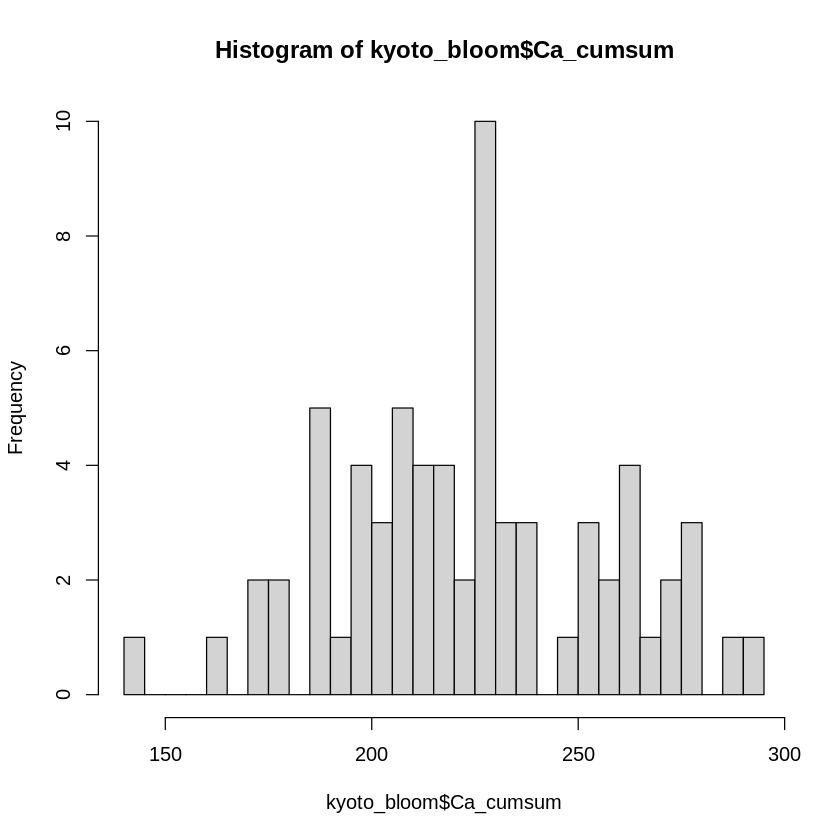

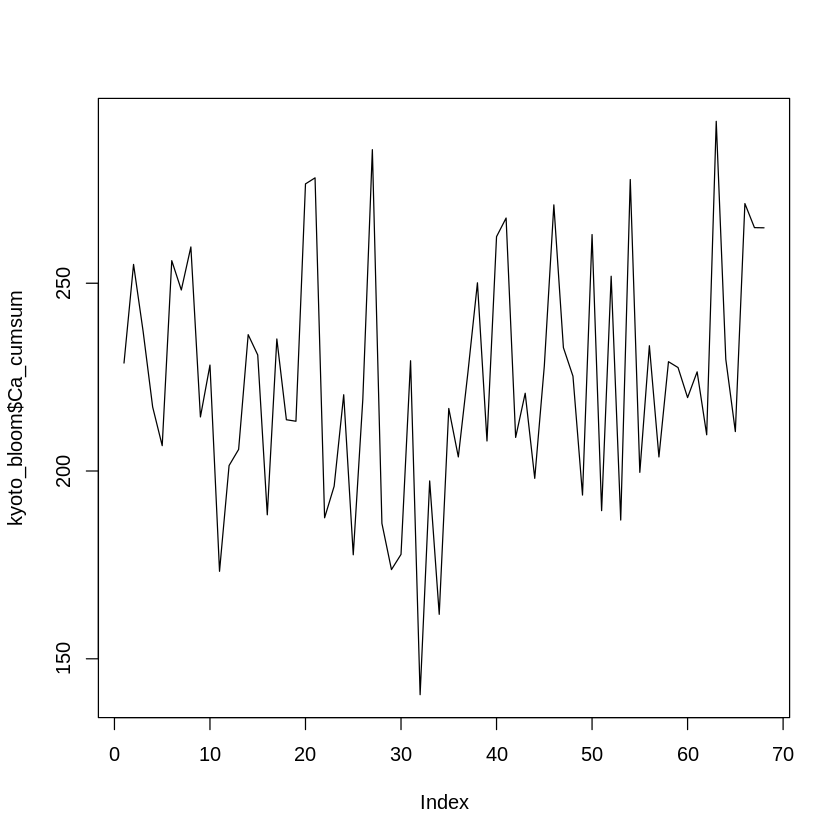

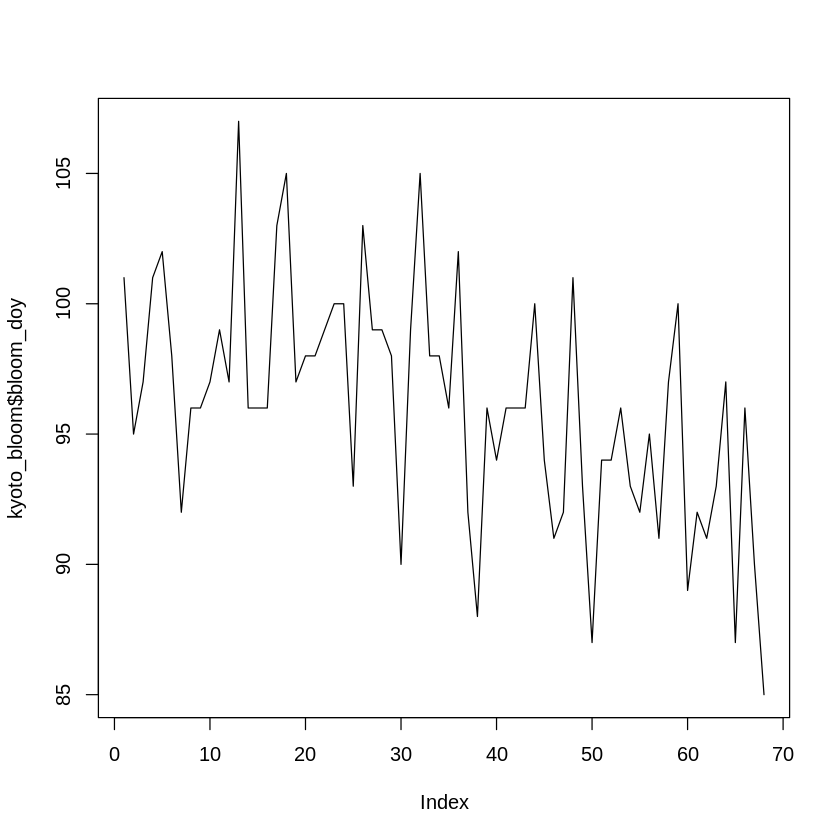

In [13]:
# kyoto_bloom_idx <- (kyoto_complete2$is_bloom == 1) & (kyoto_complete2$year > 1980)
kyoto_bloom_idx <- (kyoto_complete2$is_bloom == 1)
kyoto_bloom <- kyoto_complete2[kyoto_bloom_idx, ] %>%
    mutate(tmean = (tmax + tmin)/2) 
kyoto_bloom$idx <- seq_len(nrow(kyoto_bloom))
# dim(kyoto_bloom)
# head(kyoto_bloom)

hist(kyoto_bloom$Ca_cumsum, breaks = 30)
plot(kyoto_bloom$Ca_cumsum, type = "l")
plot(kyoto_bloom$bloom_doy, type = "l")

,Est.,St.Err.,t value,CI(95%).l,CI(95%).u
slope1,-0.99836,0.61816,-1.6151,-2.20990,0.2132
slope2,1.19650,0.47399,2.5242,0.26745,2.1255


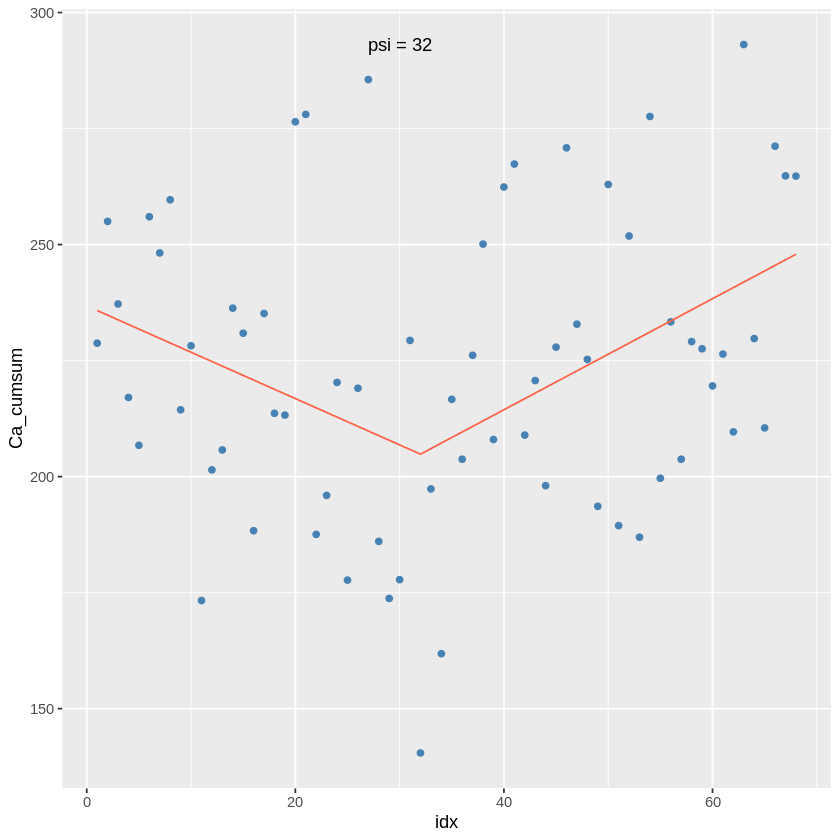

In [248]:
# perform segmented regression to find the break point.
library(segmented)
kyoto_glm <- glm(formula = Ca_cumsum ~ idx, data = kyoto_bloom, family = gaussian)
# summary(kyoto_glm)
kyoto_seg <- segmented::segmented(kyoto_glm, seg.Z = ~idx)

slope(kyoto_seg)
psi <- round(kyoto_seg$psi[, "Est."])

kyoto_fitted <- fitted(kyoto_seg)
kyoto_model <- data.frame(idx = kyoto_bloom$idx, Ca_cumsum = kyoto_fitted)

p <- ggplot(data = kyoto_bloom, aes(x = idx, y = Ca_cumsum))
p <- p + geom_point(color = "steelblue")
p <- p + geom_line(data = kyoto_model, aes(x = idx, y = Ca_cumsum), colour = "tomato")
p <- p + annotate("text", x = 30, y = max(kyoto_bloom$Ca_cumsum), label = paste0("psi = ", psi))
p